In [9]:
import scipy.stats as sts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

# Estimators
def nonParametricOptimalQuantity(distributionData, tau):
    optimalQuantity = np.quantile(distributionData,tau)
    return optimalQuantity

def profit(tau, demand, quantity):
    price = 1
    cost = 1 - tau
    return price * np.minimum(demand,quantity) - cost * quantity

def parametricOptimalQuantity(estimators, tau):
    optimalQuantity = sts.norm.ppf(tau, loc = estimators[0], scale = estimators[1])
    return optimalQuantity

def realParametricOptimalQuantity(realParameters, tau):
    # we are using lognormal here for the study
    optimalQuantity = sts.lognorm.ppf(tau, s=realParameters["shape"], loc=realParameters["location"], scale=realParameters["scale"])
    return optimalQuantity

# Evaluation of test statistics functions
def empericalRootMeanSquaredError(m, optimalQuantities, tau, realParameters):
    realOptimalQuantity = realParametricOptimalQuantity(realParameters, tau)
    rmse = np.sqrt(1/m * np.sum((optimalQuantities - realOptimalQuantity)**2))
    return rmse

def empericalRootMeanSquaredErrorRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, tau, realParameters):
    return empericalRootMeanSquaredError(m, nonParametricOptimalQuantitys, tau, realParameters) / empericalRootMeanSquaredError(m, parametricOptimalQuantitys, tau, realParameters)

def empericalServiceLevel(m, optimalQuantities, demand):
    indicatorFunction = np.where(optimalQuantities.T >= np.array(demand), 1, 0)
    return 1 / m * np.sum(indicatorFunction)

def empericalProfitLoss(m, optimalQuantities, demand, tau, realParameters, meanDemand):
    realOptimalQuantity = realParametricOptimalQuantity(realParameters, tau)
    # Is it correct to use the location param as mean?
    profitReal = profit(tau, meanDemand, realOptimalQuantity)
    profitEstimator = profit(tau, demand, optimalQuantities.T)
    return 1 / m * np.sum(np.abs((profitReal - profitEstimator) /  profitReal))

def empericalProfitLossRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, demand, tau, realParameters, meanDemand):
    return empericalProfitLoss(m, nonParametricOptimalQuantitys, demand, tau, realParameters, meanDemand) / empericalProfitLoss(m, parametricOptimalQuantitys, demand, tau, realParameters, meanDemand)

def monteCarlo(m, tau, n, realParameters):
    # Define arrays
    parametricOptimalQuantitys = np.empty((m,1))
    nonParametricOptimalQuantitys = np.empty((m,1))
    allParameters = np.empty((m,2))

    meanDemand = sts.lognorm.mean(s=realParameters["shape"], loc=realParameters["location"], scale=realParameters["scale"])
    
    # Compute estimators and optimal quantities
    for j in range(m):
        # Distribution is lognorm, we are assuming normal in the analysis
        distributionData = sts.lognorm.rvs(s=realParameters["shape"], loc=realParameters["location"], scale=realParameters["scale"], size = n)
        allParameters[j] = parameters = sts.norm.fit(distributionData)
        parametricOptimalQuantitys[j] = parametricOptimalQuantity(parameters, tau)
        nonParametricOptimalQuantitys[j] = nonParametricOptimalQuantity(distributionData, tau)
    
    demand = allParameters[:,0] # in case of normal
    # Compute evaluation statistics
    rmse = empericalRootMeanSquaredErrorRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, tau, realParameters)
    eslParametric = empericalServiceLevel(m, parametricOptimalQuantitys, demand)
    eslNonParametric = empericalServiceLevel(m, nonParametricOptimalQuantitys, demand)
    eplr = empericalProfitLossRatio(m, parametricOptimalQuantitys, nonParametricOptimalQuantitys, demand, tau, realParameters, meanDemand)
    result = {
                    'MonteCarlo iterations' : m,
                    'Sample Size': n,
                    'Target Service Level': tau,
                    'Param Values': np.mean(allParameters, axis=0),
                    'RMSE Ratio': rmse,
                    'SL nonParam': eslParametric,
                    'SL Param': eslNonParametric,
                    'EPLR': eplr
                }
    return result

In [10]:
numberOfMontecarloIterations = 1000
parameters = {"shape": 0.4, "location" : -800.0, "scale" : 1000}

tauArray = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]
nArray = [10, 50, 100, 200]

results = []
for tau in tauArray:
    for n in nArray:
        result = monteCarlo(numberOfMontecarloIterations, tau, n,parameters)
        results.append(result)


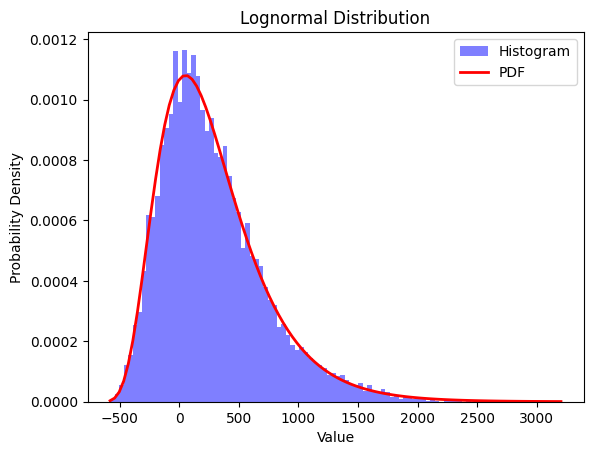

In [11]:
dist = sts.lognorm(s=parameters["shape"], loc=parameters["location"], scale=parameters["scale"])

data = dist.rvs(size=10000)

plt.hist(data, bins=100, density=True, alpha=0.5, color='b', label='Histogram')

x = np.linspace(np.min(data), np.max(data), 100)
pdf = dist.pdf(x)
plt.plot(x, pdf, 'r', linewidth=2, label='PDF')

plt.title('Lognormal Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')

plt.legend()
plt.show()

In [12]:
df = pd.DataFrame(results)
df

,MonteCarlo iterations,Sample Size,Target Service Level,Param Values,RMSE Ratio,SL nonParam,SL Param,EPLR
0,1000,10,0.01,"[273.46040215695194, 399.95739638046257]",0.584928,0.0,0.000,0.633416
1,1000,50,0.01,"[283.3088489532002, 439.12596416172903]",0.232871,0.0,0.000,0.199821
2,1000,100,0.01,"[287.13132977586656, 447.8947293883335]",0.171188,0.0,0.000,0.143811
3,1000,200,0.01,"[282.96910533586936, 448.5903548093029]",0.114435,0.0,0.000,0.094547
4,1000,10,0.05,"[285.39493691375884, 403.8123930477478]",0.752690,0.0,0.000,0.795124
5,1000,50,0.05,"[286.9085582501456, 441.7791094602933]",0.354683,0.0,0.000,0.322119
6,1000,100,0.05,"[284.23080460001626, 446.3539574319771]",0.240826,0.0,0.000,0.204271
7,1000,200,0.05,"[284.34306549138773, 449.3848376086489]",0.172027,0.0,0.000,0.142097
8,1000,10,0.10,"[278.3774935511244, 402.6779358509185]",0.963695,0.0,0.000,0.963903
9,1000,50,0.10,"[282.3856853889011, 438.4285687819032]",0.559671,0.0,0.000,0.533722


Graph data with colours!!!

In [13]:
import plotly.express as px
fig = px.scatter(df, x='Target Service Level', y='RMSE Ratio', color="Sample Size", title="TSL vs RMSE, higher RMSE means parametric performs better")
fig.show()

fig = px.scatter(df, x='Target Service Level', y='EPLR', color="Sample Size", title="TSL vs EPLR, higher EPLR means non parametric has a higher profit loss")
fig.show()

#fig = px.scatter(df, x='Target Service Level', y='RMSE Ratio', color="Sample Size", title="TSL vs RMSE, higher RMSE means parametric performs better")
#fig.show()
